In [6]:
import tensorflow
from tensorflow import keras
from keras.models import load_model
from keras.utils import to_categorical
import nibabel as nib
import numpy as np
import segmentation_models as sm
from keras.metrics import MeanIoU
import random
import matplotlib.pyplot as plt
# Note: Importing segmentation models library may give you generic_utils error on TF2.x
# When the error shows up, click the __init__.py link in the error message and change..
# keras.utils.generic_utils.get_custom_objects().update(custom_objects)
# to
# keras.utils.get_custom_objects().update(custom_objects)
# Then save the init.py file and restart runtime and run this cell

In [2]:
#Set compile=False as we are not loading it for training, only for prediction.
model = load_model('D:/MRI - Tairawhiti (User POV)/Pre-Trained Models (Google Colab)/resnet(0.91 DSC, 3 Patients, 3 Epoches)/res34_backbone_n_epochs.hdf5', compile=False)

In [3]:
pred_name = 'msk_005'
n_classes = 4

img = nib.load(("D:\MRI - Tairawhiti (User POV)/nnUNet Data/scans/{}.nii.gz").format(pred_name))
img_data = img.get_fdata()
X_test = np.repeat(img_data, 3, axis=3)
X_test = X_test[0:5]

msk = nib.load(("D:\MRI - Tairawhiti (User POV)/nnUNet Data/multiclass_masks/{}.nii.gz").format(pred_name))
y_test = msk.get_fdata()
y_test = y_test[0:5]

print("Test Images Shape: ", X_test.shape)
print("Test Masks Shape: ", y_test.shape)
print("Test Labels: ", np.unique(y_test))

##Model 
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_test_processed = preprocess_input(X_test)

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Test Images Shape:  (5, 512, 512, 3)
Test Masks Shape:  (5, 512, 512, 1)
Test Labels:  [0. 2.]


In [4]:
##Model 
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_test_processed = preprocess_input(X_test)

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [5]:
y_pred=model.predict(X_test_processed)
y_pred_argmax=np.argmax(y_pred, axis=3)

print('Pred Mask Shape: ', y_pred_argmax.shape)

# Calculate Mean IoU
mean_iou = MeanIoU(num_classes=n_classes)  # Replace n_classes with the number of classes in your segmentation task
mean_iou.update_state(y_test, y_pred_argmax)
iou = mean_iou.result().numpy()

def dice_coefficient(true_array, pred_array):
    true_array = np.asarray(true_array).astype(bool)
    pred_array = np.asarray(pred_array).astype(bool)

    intersection = np.logical_and(true_array, pred_array)
    dice = 2.0 * intersection.sum() / (true_array.sum() + pred_array.sum())
    return round(dice, 2)



y_pred_argmax = np.expand_dims(y_pred_argmax, axis = -1)

tibia_seg_data_pred = np.where(y_pred_argmax != 1, 0, 1)
femur_seg_data_pred = np.where(y_pred_argmax != 2, 0, 1)
fibula_seg_data_pred = np.where(y_pred_argmax != 3, 0, 1)

tibia_seg_data_gt = np.where(y_test != 1, 0, 1)
femur_seg_data_gt = np.where(y_test != 2, 0, 1)
fibula_seg_data_gt = np.where(y_test != 3, 0, 1)


dice_score_tibia = dice_coefficient(tibia_seg_data_gt, tibia_seg_data_pred)
dice_score_femur = dice_coefficient(femur_seg_data_gt, femur_seg_data_pred)
dice_score_fibula = dice_coefficient(fibula_seg_data_gt, fibula_seg_data_pred)


print('Mean IoU:', iou)
print('Dice Score - Tibia:', dice_score_tibia)
print('Dice Score - Femur:', dice_score_femur)
print('Dice Score - Fibula:', dice_score_fibula)

1/1 [==============================] - 5s 5s/step
Pred Mask Shape:  (5, 512, 512)
Mean IoU: 0.9111407
Dice Score - Tibia: nan
Dice Score - Femur: 0.9
Dice Score - Fibula: nan


C:\Users\GGPC\AppData\Local\Temp\ipykernel_9464\1776725933.py:16: RuntimeWarning: invalid value encountered in double_scalars
  dice = 2.0 * intersection.sum() / (true_array.sum() + pred_array.sum())


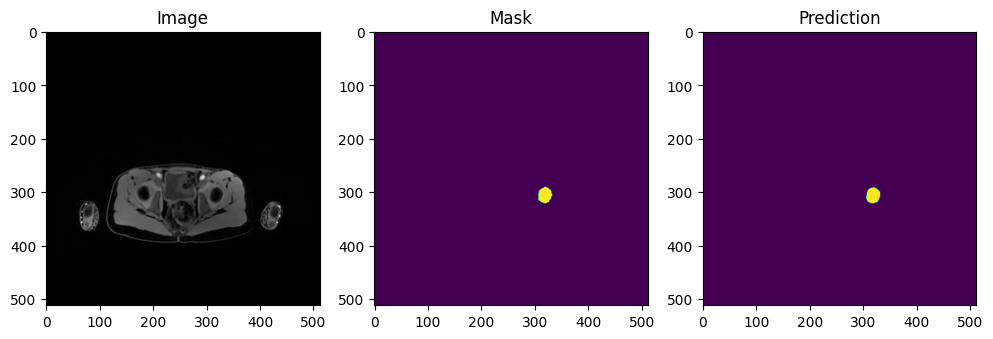

In [9]:
img_number = random.randint(0, len(X_test_processed)-1)
img = X_test_processed[img_number]
mask = y_test[img_number]
prediction = y_pred_argmax[img_number]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
plt.show()